## Imports

In [89]:
import re 
from pyteomics import fasta, parser
import gzip
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from toolz import sliding_window, get_in, interpose
from itertools import combinations, starmap
from functools import partial
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from Bio.Align import substitution_matrices
import zlib
from timeit import default_timer as timer
import sklearn


## General purpose functions and variables

In [16]:
aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

blosum62 = substitution_matrices.load('blosum62') 
bargap = 0.3

aa_encodings = dict([(aa, i) for i, aa in enumerate(aa_list)])

def encode_sequence(sequence):
    return [aa_encodings[i] for i in sequence]

def decode_sequence(encoded_sequence):
    return ''.join([aa_list[i] for i in encoded_sequence])

def alignment_score(s1, s2, substitution_matrix=None):
    return sum(map(partial(get_in, coll=substitution_matrix), zip(s1, s2)))

def similarity_dict(sequences, substitution_matrix):
    pairwise_combs = combinations(sequences, 2)
    sim_dict = defaultdict(set)
    
    for i in pairwise_combs:
        sim_dict[alignment_score(*i, substitution_matrix)].update(i)
        
    return sim_dict

## Open Fasta and extract the unique tryptic peptides
## ONLY RUN FOR NEW FASTA FILE

In [3]:
dbpath = r'C:\Users\student\Desktop/uniprotkb_Human_2024_08_16.fasta.gz'
peptides_path = r'unique_uniprot_human_tryptic_peptides.txt'
protein_sequences_path = r'unique_uniprot_human_protein_sequences.txt'

new_fasta = False

if new_fasta:
    unique_peptides = set()
    sequences = []
    
    t1 = timer()
    with gzip.open(dbpath, mode='rt') as gzfile:
        for description, sequence in fasta.FASTA(gzfile):
            sequences.append(sequence)
            new_peptides = parser.cleave(sequence, 'trypsin')
            unique_peptides.update(new_peptides)
    t2 = timer()
    print(f'Done reading fasta in {t2-t1:.3f} seconds.')
    
    t1 = timer()
    with open(peptides_path, 'w') as tp:
        tp.writelines(interpose('\n', unique_peptides))
    t2 = timer()
    print(f'Done writing unique tryptic peptides in {t2-t1:.3f} seconds.')
    
    t1 = timer()
    with open(protein_sequences_path, 'w') as ps:
        for i in list(sequences):
            ps.writelines(interpose('\n', x))
    t2 = timer()
    print(f'Done writing protein sequences in {t2-t1:.3f} seconds.')

else:
    t1 = timer()
    unique_peptides = [i.strip() for i in open(peptides_path).readlines()]
    t2 = timer()
    print(f'Done reading unique tryptic peptides in {t2-t1:.3f} seconds.')

    t1 = timer()
    sequences = [i.strip() for i in open(protein_sequences_path).readlines()]
    t2 = timer()
    print(f'Done reading protein sequences in {t2-t1:.3f} seconds.')

Done reading unique tryptic peptides in 13.709 seconds.
Done reading protein sequences in 2.471 seconds.


In [4]:
len(sequences), len(unique_peptides)

(12403543, 40604987)

In [5]:
peptide_sizes = [len(i) for i in unique_peptides]
max(peptide_sizes), min(peptide_sizes)

(6509, 1)

## Filter out peptides with unnatural aminoacids

In [6]:
unique_peptides = set(filter(lambda x: set(x)<=set(aa_list), unique_peptides))
len(unique_peptides)

40340165

## Coarse histogram of tryptic peptides by length (bin-width of 20 aa)

9.77300539999851

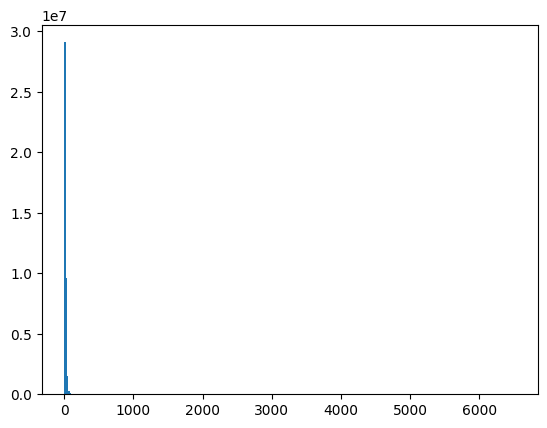

In [7]:
bin_width = 20
#t1 = timer()
#ax = plt.hist(peptide_sizes, bins=6520//bin_width, range=(0, 6520))
#t2 = timer()

t3 = timer()
size_counter = Counter(map(lambda x: x//bin_width, peptide_sizes))
bins, counts = zip(*sorted(size_counter.items(), key=lambda x: x[0]))
bins = list(map(lambda x: x*bin_width, bins))

ax = plt.bar(bins, counts, width=bin_width-bargap, align='edge')
t4 = timer()
t4-t3

Text(0, 0.5, '# of Peptides')

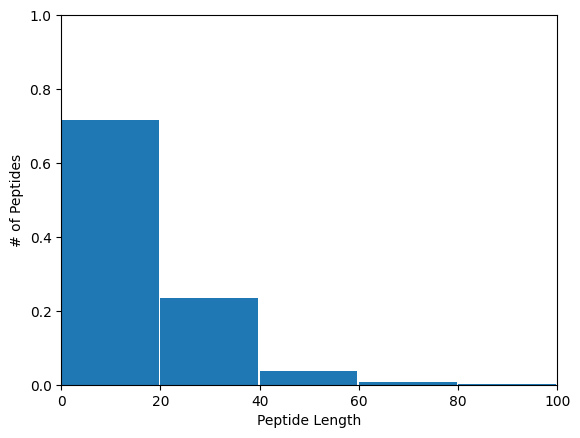

In [8]:
plt.bar(bins, list(map(lambda x: x/ax.datavalues.sum(), counts)), width=bin_width-bargap, align='edge')
plt.xlim(0,100)
plt.ylim(0,1)
plt.xlabel("Peptide Length")
plt.ylabel("# of Peptides")

In [9]:
frac = ax.datavalues/ax.datavalues.sum()
cumsum = np.cumsum(frac)
bin95 = np.min(np.where(cumsum.round(2) >= 0.95))
bin99 = np.min(np.where(cumsum.round(2) >= 0.99))
bins[bin95+1], bins[bin99+1]

(40, 60)

#### 95% of the tryptic peptides are less than 40 amino acids long.
#### 99% of the tryptic peptides are less than 60 amino acids long. 

## Downsample the number of unique peptides, and assert the new sample represents the previous distribution

In [10]:
num_peptides = int(1e6)
pep_list = list(unique_peptides)
sampled_peptides = [pep_list[i] for i in np.random.choice(len(unique_peptides), num_peptides, replace=False)]

In [96]:
#num_peptides_small = int(52350)
#pep_list_small = list(unique_peptides)
#sampled_peptides_small = [pep_list[i] for i in np.random.choice(len(unique_peptides), num_peptides_small, replace=False)]
#len5to40 = filter(lambda x: 5<=len(x)<=40, sampled_peptides_small)
#
#with open('peptides_filtered_40orlessAA_50000.txt', 'w') as filtpep:
#    filtpep.writelines(interpose('\n', len5to40))
#with open('peptides_filtered_40orlessAA_50000.txt', 'r') as filtpep:
#    print(len(filtpep.readlines())) # should be less than num_peptides_small

49906


Text(0.5, 1.0, '1,000,000 Sampled Peptides')

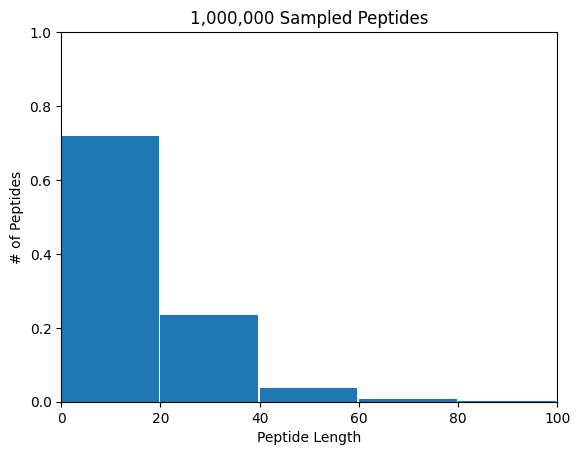

In [11]:
bin_width = 20
binned_lengths = map(lambda x: x//bin_width, map(len, sampled_peptides))
length_counts = Counter(binned_lengths)

x = length_counts.keys()
y = length_counts.values()
plt.bar([i*bin_width for i in x], [i/num_peptides for i in y], width=bin_width-bargap, align='edge')
plt.xlim(0,100)
plt.ylim(0,1)
plt.xlabel("Peptide Length")
plt.ylabel("# of Peptides")
plt.title(f"{num_peptides:,} Sampled Peptides")

Found 351061 unique digestion peptides between 5-10 amino acids.
7972 are 5 amino acids long.
43759 are 6 amino acids long.
82524 are 7 amino acids long.
80392 are 8 amino acids long.
71618 are 9 amino acids long.
64796 are 10 amino acids long.


Text(0.5, 0, 'Peptide Length')

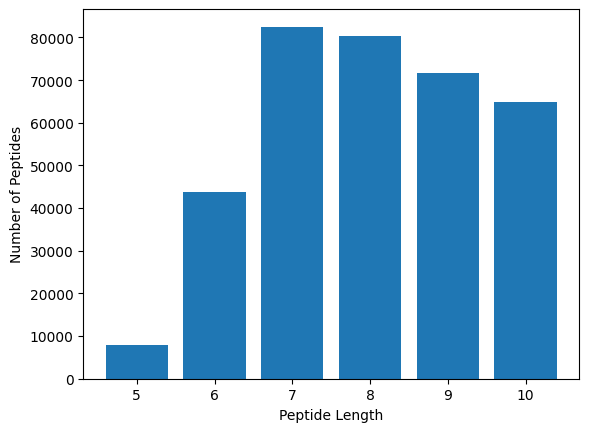

In [12]:
min_length = 5
max_length = 10

peptides_filtered = set(filter(lambda x: min_length<=len(x)<=max_length, sampled_peptides))
peptides_filtered_dict = dict([(i, []) for i in range(min_length, max_length+1)])
for pep in peptides_filtered:
    peptides_filtered_dict[len(pep)].append(pep)

print(f'Found {len(peptides_filtered)} unique digestion peptides between {min_length}-{max_length} amino acids.')
for size in sorted(peptides_filtered_dict.keys()):
    print(f'{len(peptides_filtered_dict[size])} are {size} amino acids long.')

plt.bar(range(min_length, max_length+1), [len(peptides_filtered_dict[i]) for i in range(min_length, max_length+1)])
plt.ylabel('Number of Peptides')
plt.xlabel('Peptide Length')

In [20]:
sm = similarity_matrix(peptides_filtered_dict[5], blosum62)
print(min(sm), max(sm))

-19.0 37.0


In [22]:
most_dissimilar_peptides = set()

neg_scores = list(filter(lambda x: x<0, sm))
for k in neg_scores:
    for i in sm[k]:
        most_dissimilar_peptides.add(i)

num_diff_peptides = len(most_dissimilar_peptides)
num_diff_peptides

7972

In [25]:
distance_matrix = np.zeros((num_diff_peptides, num_diff_peptides))
ordered_peptides = list(most_dissimilar_peptides)

t1 = timer()
for i, j in combinations(range(num_diff_peptides), 2):
    distance_matrix[i, j] = distance_matrix[j, i] = alignment_score(ordered_peptides[i], ordered_peptides[j], blosum62)

    
#t2 = timer()
#t2-t1, distance_matrix[0], broadcast(10, 10)

100

In [ ]:
def coverage(sequence, subsequences):
    covered_positions = set()
    
    for subseq in subsequences:
        start = sequence.find(subseq)
        while start != -1:
            covered_positions.update(set(range(start, start + len(subseq))))
            start = sequence.find(subseq, start + 1)
    coverage_percentage = (len(covered_positions) / len(sequence)) * 100
    return coverage_percentage
    

min_kmer_k = 4
max_kmer_k = 7 # goal 10?
peptide_kmer_dict = {}

coverages = []
for pep6 in unique_peptides_5to20aa_dict[6]:
    pep5s = unique_peptides_5to20aa_dict[5]
    coverages.append(coverage(pep6, pep5s))
coverages/len(coverages)

In [ ]:
unique_kmers = []
k = 5
for i in unique_peptides_lessthan_20aa:
    kmers = [i[n:n+k] for n in range(len(i)-k)]
    for j in kmers:
        if j not in unique_kmers:
            unique_kmers.append(j)
len(unique_kmers)

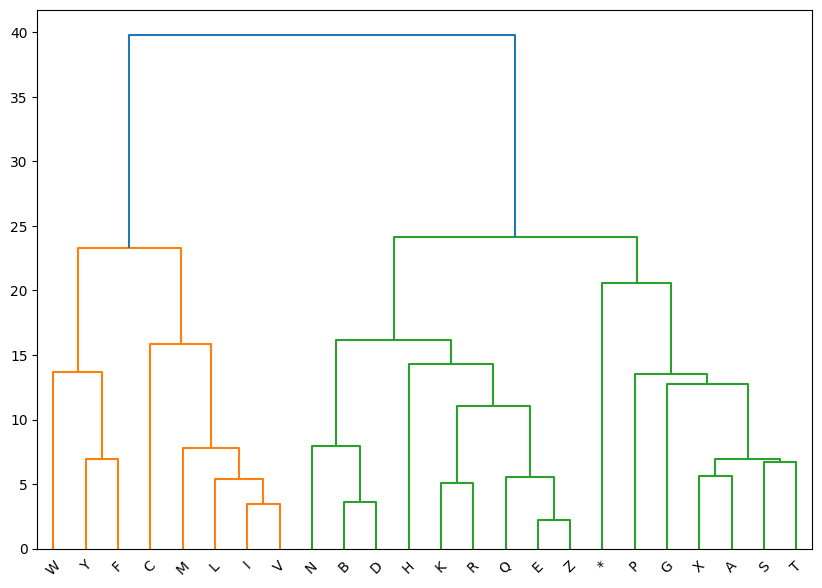

In [360]:
linked = linkage(blosum62, 'ward', optimal_ordering=True)

plt.figure(figsize=(10, 7))
x = dendrogram(linked,
           orientation='top',
           labels=blosum62.alphabet,
           distance_sort='ascending',
           show_leaf_counts=True)
plt.show()

In [373]:
np.random.seed(5)
blosum90 = substitution_matrices.load("RAO")
mds = sklearn.manifold.MDS(n_components=1, 
                           n_init = 50, 
                           max_iter = 100000, 
                           eps = 1e-10,
                           verbose=False,
                           dissimilarity='precomputed')
fit = mds.fit(np.array(blosum90.data)*-1)

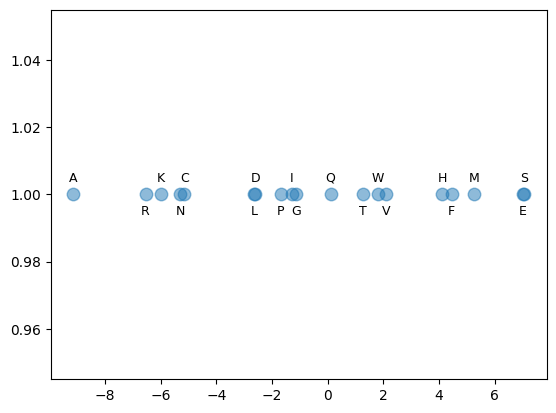

In [374]:
fontsize=9
labeled_embeddings = sorted([(fit.embedding_[:-1][i][0], blosum90.alphabet[:-1][i]) for i in range(len(fit.embedding_)-1)])

x, labels = list(zip(*labeled_embeddings))
y = np.ones(len(blosum90.alphabet)-1)
plt.scatter(x, y, alpha=0.5, s=fontsize**2)

for i, label in enumerate(labels):
    plt.text(x[i], y[i]+0.005*(-1)**i, label, fontsize=fontsize, ha='center', va='center')